## DNA Case Study (Optional)

Author: Danis Alukaev <br>
Email: d.alukaev@innopolis.university <br>
Group: B19-DS-01

#### 0. Prerequisites.

Since there is a bug in `scipy` chi-square test implementation, make sure that version is `1.6.0`.

In [1]:
!pip install scipy==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from math import ceil, factorial, exp
from scipy import stats

np.random.seed(0)

Let's start with importing the given data from `hcmv.data.txt`. The file is comprised of integer CMV palindrome locations for the 296 palindromes each at least ten base pairs long.

In [3]:
def read_hmcv_data(path):
    with open(path) as f:    
        lines = f.readlines()[1:-1]
    locations = [int(line.replace(" ", "").replace("\n", "")) for line in lines]
    locations = np.array(locations)
    return locations

path = "hcmv.data.txt"
locations = read_hmcv_data(path)

In [4]:
print(f"Head of array: {locations[:5]}")

Head of array: [ 177 1321 1433 1477 3248]


In [5]:
print(f"Range of locations is [{locations.min()}, {locations.max()}]")

Range of locations is [177, 228953]


#### 1. Random scatter.

To get an intuition about the data, let's firstly plot the graph of palindrome locations.

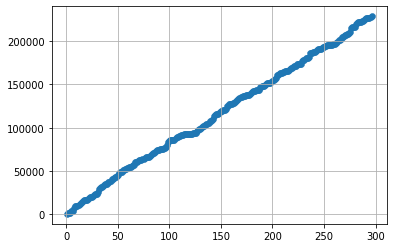

In [6]:
def plot_scatter(locations):
    plt.scatter(range(1, len(locations) + 1), locations, linewidths=0.5)
    plt.grid()
    plt.plot()

plot_scatter(locations)

As you can see, it pretty much reflects linear dependency. We can verify it using linear regression from `scikit-learn`: if $R^2$ is nearly 1.0, then line can explain given data and our speculation is true. 

In [7]:
def get_r_squared(data):
    model = LinearRegression()
    X = np.array(range(1, len(data) + 1)).reshape(-1, 1)
    Y = np.array(data)
    model.fit(X, Y)
    r_squared = model.score(X, Y)
    return r_squared

r_squared = get_r_squared(locations)
print(f"R-squared is {r_squared}")

R-squared is 0.9984515619010546


Wow! It's definitly shows linear relation. Therefore, in further sections we will use linear (uniform) random sampling for simulated data.

As suggested in the paper, the starting point can be checking how random scatter looks compared to real data. 

In [8]:
N_SAMPLES = 2
BASES = 229_354
N_PALINDROMS = 296

In [9]:
def generate_simulation(bases, n_palindromes):
    simulation = np.random.randint(bases, size=n_palindromes)
    simulation = np.sort(simulation)
    return simulation

In [10]:
def plot_scatters(samples, legends, colors):
    for sample, legend, color in zip(samples, legends, colors):
        plt.scatter(range(1, len(sample) + 1), sample, linewidths=0.5, c=color, label=legend, alpha=0.5)
    plt.legend()
    plt.grid()
    plt.plot()

In [11]:
samples = [locations] + [generate_simulation(BASES, N_PALINDROMS) for _ in range(N_SAMPLES)]
legends = ["real"] + [f"synthetic #{i + 1}" for i in range(N_SAMPLES)]
colors = [np.random.rand(3,).reshape(1,-1) for _ in range(N_SAMPLES + 1)]

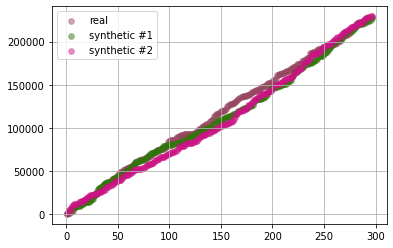

In [12]:
plot_scatters(samples, legends, colors)

Look pretty similar! Let's now check r-squared for all samples.

In [13]:
for sample, legend in zip(samples, legends):
    r_squared = get_r_squared(sample)
    print(f"R-squared for '{legend}' is {r_squared}")

R-squared for 'real' is 0.9984515619010546
R-squared for 'synthetic #1' is 0.993602796355477
R-squared for 'synthetic #2' is 0.9920812691989909


Further we can use Kolmogorov-Smirnov test to check whether real and synthetic data come from the same distribution. Let the results be statistically significant at a P-value of 0.05.

**Null hypothesis:** Both data samples come from the same distribution. <br>
**Alternative hypothesis:** Data samples come from the different distributions.

In [14]:
for i in range(1, N_SAMPLES + 1):
    pvalue = stats.ks_2samp(samples[0], samples[2]).pvalue 
    if pvalue < 0.05:
        print(f"Reject null hypothesis for KS({legends[0]}, {legends[i]}). Accept alternative.")
    else:
        print(f"Cannot reject null hypothesis for KS({legends[0]}, {legends[i]}).")

Cannot reject null hypothesis for KS(real, synthetic #1).
Cannot reject null hypothesis for KS(real, synthetic #2).


#### 2. Locations and spacings.

Although scatter plot provided us with an intuition about data, for us it will be beneficial to consider palindrome locations as ticks on horizontal line (see Figure 4.1).

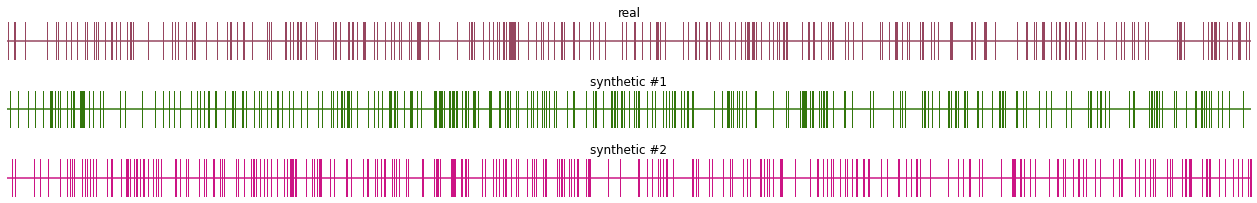

In [15]:
def plot_locations_ticks(samples, legends, colors, bases=BASES):
    n_samples = len(samples)
    n_palindromes = len(samples[0])
    fig, axes = plt.subplots(n_samples, 1)
    fig.set_size_inches(18, n_samples)
    fig.tight_layout()

    for ax, sample, legend, color in zip(axes, samples, legends, colors):
        ax.hlines(1, 1, bases, color=color)
        ax.set_xlim([0, bases + 1])
        ax.set_ylim(0.5, 1.5)
        ax.set_title(legend)
        y = np.ones(n_palindromes)
        ax.plot(sample, y, '|', ms=40, color=color)
        ax.set_axis_off()
    plt.show()

plot_locations_ticks(samples, legends, colors)

Now when the spacings between palindromes are more evident for us, let's examine the spacings between consecutive palindromes and sums of consecutive pairs, triplets.

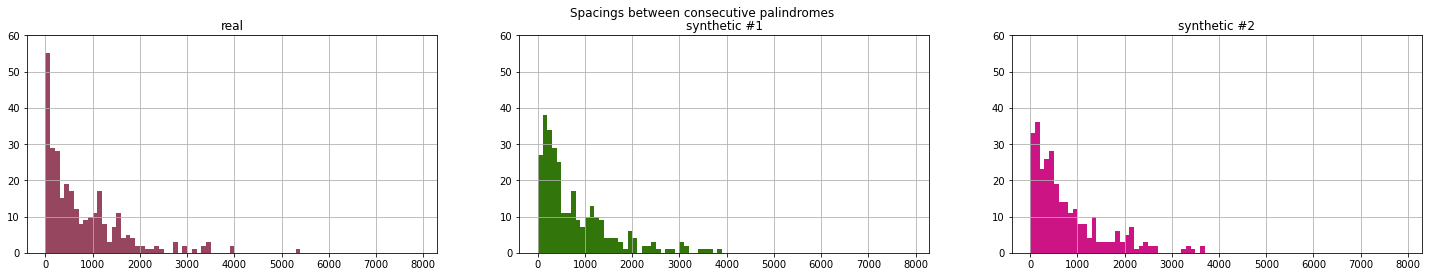

In [16]:
def hist_spacings(samples, legends, colors, caption=None, offset=1, bins=range(0, 8000, 100)):
    spacings = [sample[offset:] - sample[:-offset] for sample in samples]
    hists = [np.histogram(spacing, bins=bins) for spacing in spacings]
    max_count = max([c.max() for c, _ in hists])
    n_samples = len(samples)
    
    fig, axes = plt.subplots(1, n_samples)
    fig.set_size_inches(25, 4)
    if caption:
        fig.suptitle(caption)
    
    for ax, hist, legend, color in zip(axes, hists, legends, colors):
        counts, bins = hist
        ax.set_title(legend)
        ax.hist(bins[:-1], bins, weights=counts, color=color)
        ax.grid()
        ax.set_ylim([0, max_count + ceil(max_count / 11)])
    plt.show()

hist_spacings(samples, legends, colors, "Spacings between consecutive palindromes", offset=1)

Note that overall shape of these distributions is quite similar. However, real data contains much more spacings less than 100.

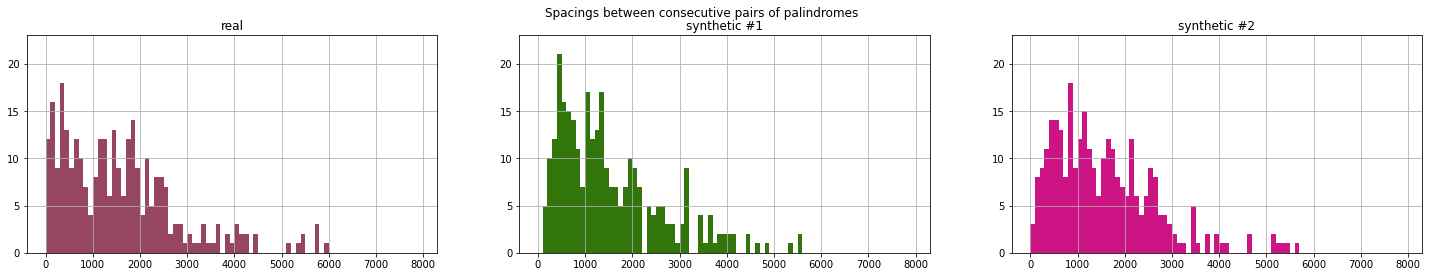

In [17]:
hist_spacings(samples, legends, colors, "Spacings between consecutive pairs of palindromes", offset=2)

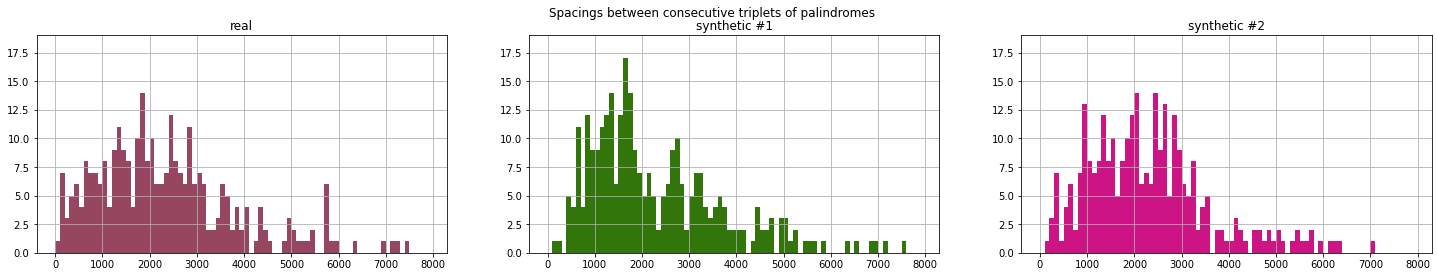

In [18]:
hist_spacings(samples, legends, colors, "Spacings between consecutive triplets of palindromes", offset=3)

From graphs of spacing of consecutive pairs and triplets, we can see that real data is more positively skewed indicating a larger number of palindromes at a shorter distance. 

#### 3. Counts.

Let's split DNA into nonoverlapping regions of equal length, and count number of palindromes in each region. Further, we can group regions by number of occurences and plot the histogram.

In [19]:
def count_palindromes(sample, bases=BASES, size=1000):
    n_palindromes = np.array([((sample >= i - size) & (sample < i)).astype(int).sum() for i in range(size, bases, size)])
    return n_palindromes

def count_region(sample, bases=BASES, size=1000):
    n_palindromes = count_palindromes(sample, bases, size)
    unique, counts = np.unique(n_palindromes, return_counts=True)
    dict_res = dict(zip(unique, counts))
    for i in range(unique.max()):
        if i not in dict_res:
            dict_res[i] = 0
    return dict_res

observed_100 = count_region(samples[0], size=100)

In [20]:
observed_100

{0: 2026, 1: 243, 2: 20, 3: 3, 4: 1}

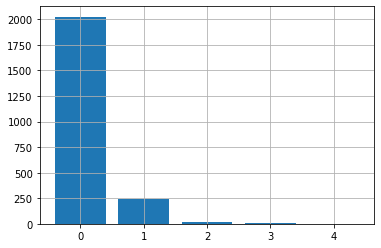

In [21]:
def plot_hist_occurences(observed):
    plt.bar(observed.keys(), observed.values())
    plt.grid()
    plt.plot()
  
plot_hist_occurences(observed_100)

In [22]:
observed_1000 = count_region(samples[0], size=1000)

In [23]:
observed_1000

{0: 67, 1: 87, 2: 35, 3: 28, 4: 10, 7: 1, 8: 1, 5: 0, 6: 0}

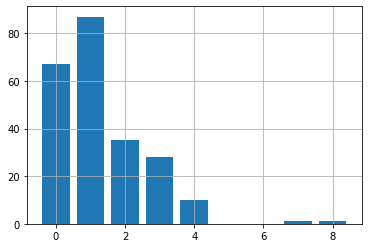

In [24]:
plot_hist_occurences(observed_1000)

In [25]:
retrieve_items = lambda x: np.array([x[i] for i in range(len(x))])

observed_100_np = retrieve_items(observed_100)
observed_1000_np = retrieve_items(observed_1000)

In [26]:
print(f"Variance for shorter vs. longer regions: {observed_100_np.var()} vs. {observed_1000_np.var()}")

Variance for shorter vs. longer regions: 622513.04 vs. 926.9135802469136


The counts for shorter regions are more variable than those for longer regions.

For further experiments region size of 1000 seems to be natural choice.

In [27]:
observed = observed_1000

We can model number of palindrome occurrences using Poisson distribution. Recall that probability $p$ of $k$ points to be in a region is given by:
$$p = \frac{\lambda ^ k e^{-\lambda}}{k!} $$

In [28]:
poisson = lambda lam, k: lam ** k / factorial(k) * exp(-lam)

In [29]:
def approximate_region(max_k, bases=BASES, n_palindromes=N_PALINDROMS, size=1000):
    dict_res = dict()
    for k in range(max_k + 1):
        lam = n_palindromes / (bases / size)
        dict_res[k] = bases / size * poisson(lam, k)
    return dict_res

In [30]:
theoretical = approximate_region(max(observed.keys()))

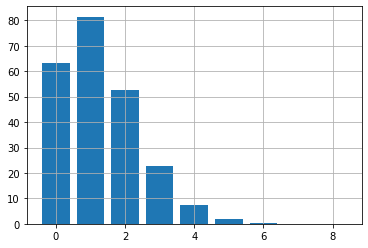

In [31]:
plot_hist_occurences(theoretical)

Remarkably, the overall shape of theoretical distribution is quite similar to observed one. Now it makes sense to use $χ^2$ test to check how well Poisson distribution fits the real data. 


**Null hypothesis:** Real data follow the Poisson distribution. <br>
**Alternative hypothesis:** Real data does not follow the Poisson distribution.

Let significance level be $\alpha=0.05$.


In [32]:
observed_items = retrieve_items(observed)
theoretical_items = retrieve_items(theoretical)

In documentation of `scipy` it is said that for chi-square test to work, all of the observed and expected frequencies should be at least 5. Therefore, I suggest to filter out values less than 5.

In [33]:
prepare_chi_square = lambda o, t, thresh=5: (o[o >= thresh], t[:len(o)][o >= thresh])

observed_items_p, theoretical_items_p = prepare_chi_square(observed_items, theoretical_items)

In [34]:
def test_hypothesis_chi_square(observed, theoretical):
    pvalue = stats.chisquare(observed, f_exp=theoretical).pvalue 

    if pvalue < 0.05:
        print(f"Reject null hypothesis for chi-square test. Accept alternative.")
    else:
        print(f"Cannot reject null hypothesis for chi-square test.")

test_hypothesis_chi_square(observed_items_p, theoretical_items_p)

Cannot reject null hypothesis for chi-square test.


Similar can be done with synthetic data.

In [35]:
for sample in samples[1:]:
    observed_ = count_region(sample)
    observed_items_ = retrieve_items(observed_)
    observed_items_p_, theoretical_items_p_ = prepare_chi_square(observed_items_, theoretical_items)
    test_hypothesis_chi_square(observed_items_p_, theoretical_items_p_)

Cannot reject null hypothesis for chi-square test.
Cannot reject null hypothesis for chi-square test.


#### 4. The biggest cluster.

The good starting point for finding the biggest cluster of palindromes is by visual inspection of frequencies in different regions. Going from longer regions to smaller regions we expect to find the area with largest number of palindromes.

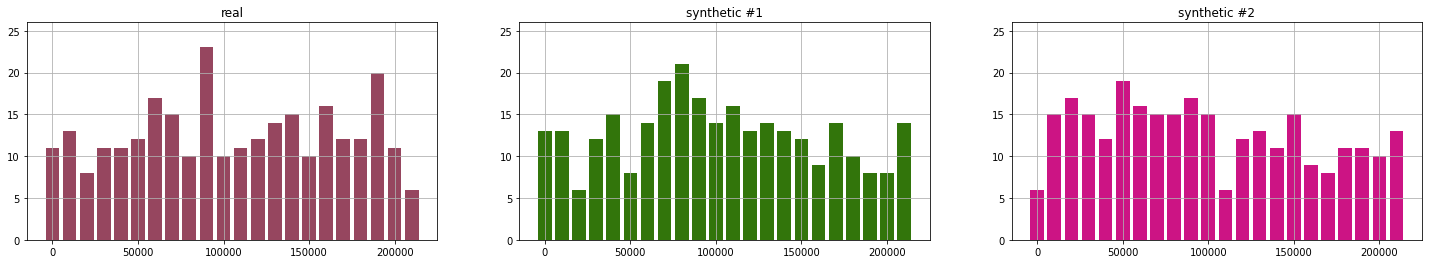

In [36]:
def hist_palindromes(samples, legends, colors, size=10000):
    n_palindromes = [count_palindromes(sample, bases=BASES, size=size) for sample in samples]
    max_count = max([max(n_palindrome) for n_palindrome in n_palindromes])
    n_samples = len(samples)
    
    fig, axes = plt.subplots(1, n_samples)
    fig.set_size_inches(25, 4)
    
    for ax, n_palindrome, legend, color in zip(axes, n_palindromes, legends, colors):
        ax.set_title(legend)
        ax.bar(np.array(range(len(n_palindrome))) * size, n_palindrome, width=size * 0.8, color=color)
        ax.set_ylim([0, max_count + ceil(max_count * 0.1)])
        ax.grid()
    plt.show()

hist_palindromes(samples, legends, colors, size=10000) 

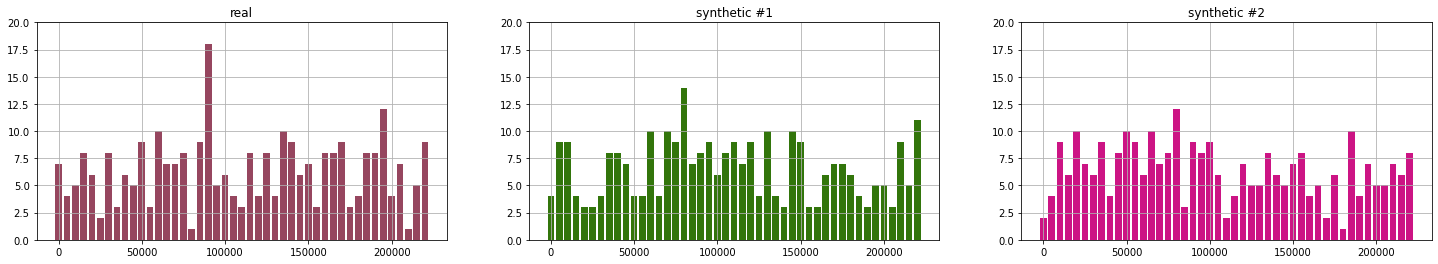

In [37]:
hist_palindromes(samples, legends, colors, size=5000) 

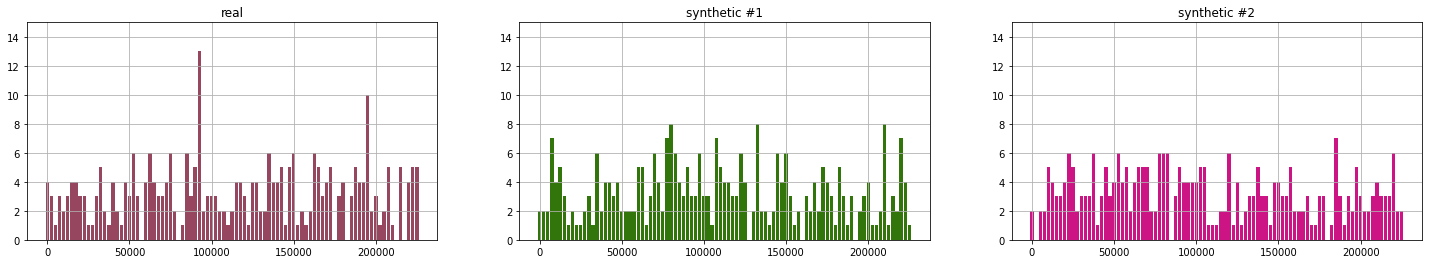

In [38]:
hist_palindromes(samples, legends, colors, size=2500) 

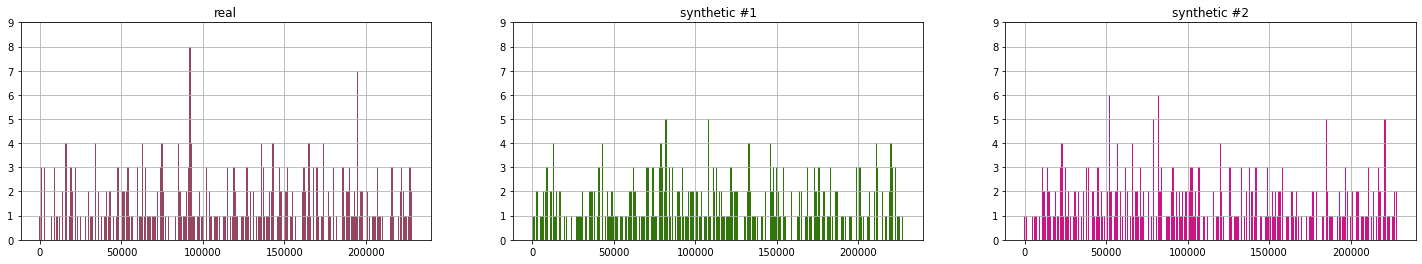

In [39]:
hist_palindromes(samples, legends, colors, size=1000) 

Here we can observe that there is a potential origin of replication of size 8. Let's find the exact location of these palindromes.

In [40]:
size = 1000

anchors = np.where(count_palindromes(samples[0], bases=BASES, size=size) == 8)[0] 
print(f"Anchor positions for biggest cluster: {[anchor * size for anchor in anchors]}")

Anchor positions for biggest cluster: [92000]


In [41]:
size = 500

anchors = np.where(count_palindromes(samples[0], bases=BASES, size=size) == 8)[0] 
print(f"Anchor positions for biggest cluster: {[anchor * size for anchor in anchors]}")

Anchor positions for biggest cluster: [92500]


Thus, the biggest cluster of palindromes of length 8 is located around 92500 with a region size 500. 

In [42]:
def find_clusters_synthetic(n_experiments, size=500):
    with_clusters = 0
    for _ in range(n_experiments):
        sample = generate_simulation(BASES, N_PALINDROMS)
        contains_cluster = len(np.where(count_palindromes(sample, bases=BASES, size=size) == 8)[0]) > 0
        with_clusters += int(contains_cluster)
    return with_clusters


N_EXPERIMENTS = 100000
with_clusters = find_clusters_synthetic(N_EXPERIMENTS)

print(f"Probability to observe cluster of 8 palindromes is {with_clusters} / {N_EXPERIMENTS} or {with_clusters / N_EXPERIMENTS}")

Probability to observe cluster of 8 palindromes is 17 / 100000 or 0.00017


From these simulations we can conclude that observation of 8 palindromes is statistically significant and indeed tend to be origin of replication.

#### Conclusion.
I would suggest a biologist to use this `.ipynb` notebook as an interactive tool to experimentally search for the origin of replication. Luckily, each step was described in detail.